# Kaggle Competition:  Iceberg or Ship
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

## Notebook 1:  Set up data

In [1]:
!ls -l

total 3120
-rw-rw-r-- 1 nidhin nidhin 1455693 Jan 15 00:32 1_getdata-Copy1.ipynb
-rw-rw-r-- 1 nidhin nidhin  625023 Jan 14 20:09 1_getdata.ipynb
-rw-rw-r-- 1 nidhin nidhin  245619 Jan 13 21:50 2_model_resnet34.ipynb
-rw-rw-r-- 1 nidhin nidhin   14278 Jan 14 01:06 3_model_resnext50-Copy1.ipynb
-rw-rw-r-- 1 nidhin nidhin   13742 Jan 14 20:20 3_model_resnext50.ipynb
-rw-rw-r-- 1 nidhin nidhin   14220 Jan 14 20:09 4_model_nasnet.ipynb
-rw-rw-r-- 1 nidhin nidhin   64965 Jan 14 00:26 4_resnext_resize.ipynb
-rw-rw-r-- 1 nidhin nidhin  147085 Jan 14 20:13 5_resnet18_resize.ipynb
-rw-rw-r-- 1 nidhin nidhin  147648 Jan 14 20:18 6_np_resnet18_resize-multiple.ipynb
-rw-rw-r-- 1 nidhin nidhin  137540 Jan 14 21:35 baseline.ipynb
-rw-rw-r-- 1 nidhin nidhin    2603 Jan 15 00:30 helper.py
drwxrwxr-x 3 nidhin nidhin    4096 Jan 14 21:25 home
-rw-rw-r-- 1 nidhin nidhin  192130 Jan 14 21:47 other_groverpr.ipynb
drwxrwxr-x 2 nidhin nidhin    4096 Jan 15 00:31 __pycache__
-rw-rw-r-- 1 nidhin nidhin     461 

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# update `.bashrc` file 
#import sys
#sys.path.insert(0,'/home/nidhin/fastai')

#export PYTHONPATH=$PYTHONPATH:/home/nidhin/fastai


In [4]:
from fastai.imports import *

In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
import shutil
from IPython.display import FileLink, FileLinks

from sklearn.model_selection import train_test_split
import helper

In [6]:
#PATH = "/home/nidhin/data/iceberg/"
PATH = os.path.expanduser("~/data/iceberg/")

In [7]:
!ls -l {PATH}

total 1975668
drwxrwxr-x  6 nidhin nidhin       4096 Jan 14 01:19 composites
drwxrwxr-x  2 nidhin nidhin       4096 Jan 13 19:06 models
-rw-rw-r--  1 nidhin nidhin     117951 Oct 23 17:27 sample_submission.csv
-rw-rw-r--  1 nidhin nidhin      38566 Jan  7 20:28 sample_submission.csv.7z
drwxrwxr-x  4 nidhin nidhin       4096 Jan 14 20:06 sub
drwxrwxr-x  2 nidhin nidhin       4096 Jan 14 21:39 test
-rw-rw-r--  1 nidhin nidhin      75819 Jan 14 21:40 test.csv
drwxrwxr-x  2 nidhin nidhin     286720 Jan 14 21:33 test-jpeg
-rw-rw-r--  1 nidhin nidhin 1521771850 Oct 23 17:27 test.json
-rw-rw-r--  1 nidhin nidhin  257127394 Jan  7 20:28 test.json.7z
drwxrwxr-x 15 nidhin nidhin       4096 Jan 13 21:50 tmp
drwxrwxr-x  4 nidhin nidhin       4096 Jan 14 21:39 train
-rw-rw-r--  1 nidhin nidhin      21714 Jan 14 21:40 train.csv
drwxrwxr-x  2 nidhin nidhin      61440 Jan 14 21:40 train-jpeg
-rw-rw-r--  1 nidhin nidhin  196313674 Oct 23 17:23 train.json
-rw-rw-r--  1 nidhin nidhin   44932785 Jan  7 20

In [8]:
class_map = {1:'ice',0:'ship'}

In [9]:
train_df = pd.read_json(PATH+"/train.json")
train_df['classes'] = train_df['is_iceberg'].map(class_map)

test_df = pd.read_json(PATH+"/test.json")


In [10]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg,classes
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,ship
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,ship
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,ice
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,ship
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,ship


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, train_df['is_iceberg'], test_size=0.20, random_state=42)

In [12]:
def normalize_band(band):
    normalized_band = (band-np.min(band))/(np.max(band)-np.min(band))
    
    band = np.array(normalized_band).reshape((75, 75))
    pband = band - np.mean(band)
    pband[pband < band.std() * 2] = 0
    pband = np.mean(np.abs(np.gradient(pband)),axis=0)
    return pband
    
    #positive = band + np.amin(band)
    #normalized = positive / np.amax(positive)
    
    #return normalized
    
    #return band

    
def color_composite(band):
    band = np.array(band)
    band = band.reshape(75, 75)
    
    modified_band = (band + abs(band.min())) / np.max((band + abs(band.min())))
    
    return modified_band
    
def scale_image(row):
    band_1 = color_composite(row['band_1'])
    band_2 = color_composite(row['band_2'])
        
    #band_3 = normalize_band(band_1 + band_2)
    band_3 = color_composite(np.array(row['band_1'])/np.array(row['band_2']))

    return np.dstack((band_1, band_2, band_3))
    
def get_scaled_imgs(df):
    imgs = []
    for i, row in df.iterrows():
        
        imgs.append ( scale_image(row)) 

    return np.array(imgs)



In [13]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg,classes
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,ship
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,ship
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,ice
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,ship
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,ship


In [14]:
X_all = get_scaled_imgs(train_df)
#test_all = get_scaled_imgs(test_df)
#y_all = train_df['is_iceberg'].head(10)
y_classes = train_df['classes']

In [15]:
len(X_all)

1604

## View images

In [16]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [17]:
X_all.shape

(1604, 75, 75, 3)

In [18]:
X_all[0:5,:,:,0].shape

(5, 75, 75)

Band 1


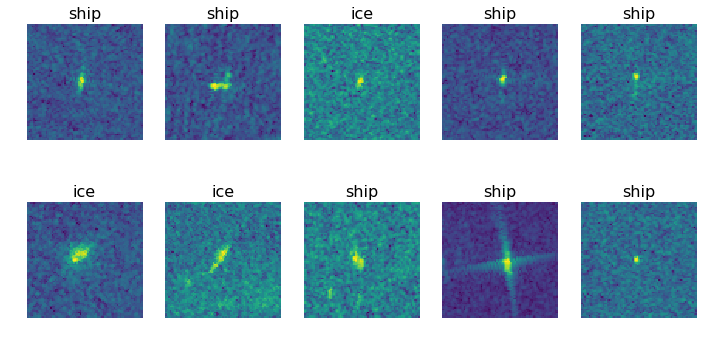

In [19]:
print("Band 1")
plots(X_all[0:10,:,:,0],rows=2, titles=y_classes[0:10])

Band 2


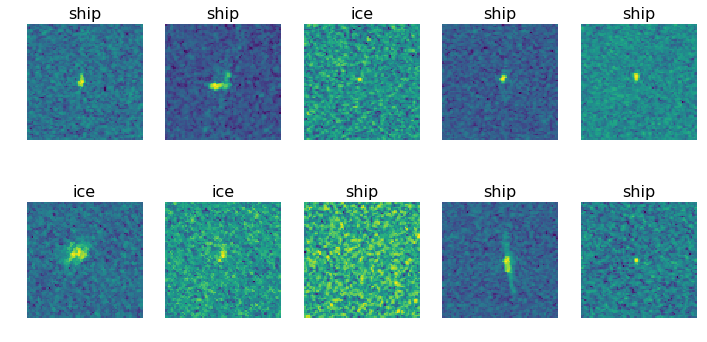

In [20]:
print("Band 2")
plots(X_all[0:10:,:,:,1],rows=2, titles=y_classes[0:10])

Band 3


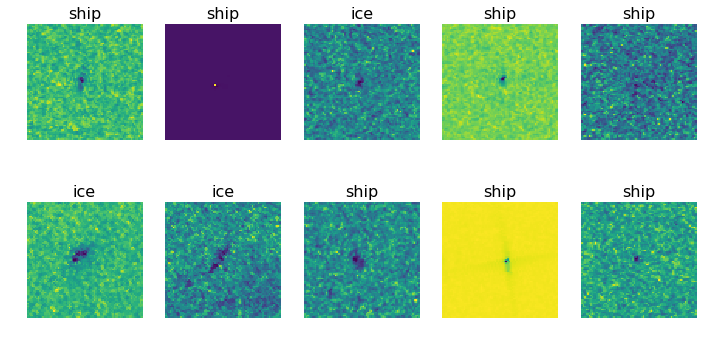

In [21]:
print("Band 3")
plots(X_all[0:10:,:,:,2],rows=2, titles=y_classes[0:10])

All Bands


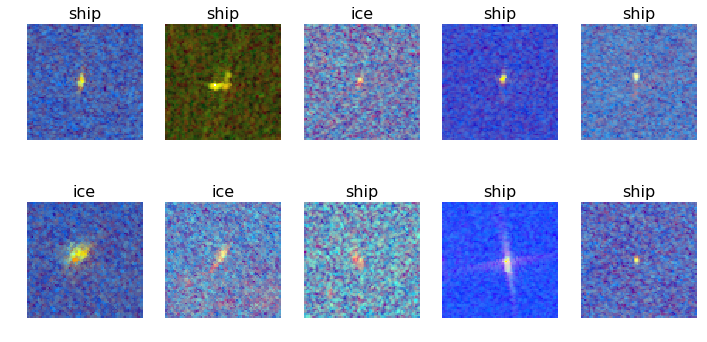

In [22]:
print("All Bands")
plots(X_all[0:10:,:,:],rows=2, titles=y_classes[0:10])

In [23]:
# see breakdown of classes in training dataset
train_df['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [24]:
# get percents
train_df['is_iceberg'].value_counts(normalize=True)

0    0.530549
1    0.469451
Name: is_iceberg, dtype: float64

## Separate out Train / Test data

In [25]:
for img_class in class_map.values():
    shutil.rmtree(f"{PATH}train/{img_class}",ignore_errors=True)
    os.makedirs(f"{PATH}train/{img_class}")

    shutil.rmtree(f"{PATH}train-jpeg/{img_class}",ignore_errors=True)
    os.makedirs(f"{PATH}train-jpeg/{img_class}")
    
    
    shutil.rmtree(f"{PATH}valid/{img_class}",ignore_errors=True)
    os.makedirs(f"{PATH}valid/{img_class}")
    
    shutil.rmtree(f"{PATH}test",ignore_errors=True)
    os.makedirs(f"{PATH}test")
    shutil.rmtree(f"{PATH}test-jpeg",ignore_errors=True)
    os.makedirs(f"{PATH}test-jpeg")
        

def save_images(images_df,folder):
    print (f"Saving {folder}")
    if "classes" in images_df:
        for _,img_row in images_df.iterrows():
            label = img_row['classes']
            normalized_img = scale_image(img_row)
            img_id = img_row["id"]
            plt.imsave(f"{PATH}{folder}/{label}/{img_id}.jpeg",normalized_img)
    else:
        # only for test
        for _,img_row in images_df.iterrows():
            normalized_img = scale_image(img_row)
            img_id = img_row["id"]
            plt.imsave(f"{PATH}{folder}/{img_id}.jpeg",normalized_img)
            
def save_images_csv(images_df,folder,is_training=True):
    print (f"Saving {folder}")
    
    if is_training:
        image_folder = f"{folder}/train-jpeg"
        images_df[['id','classes']].to_csv(f"{folder}/train.csv",index=False)
    else:
        image_folder = f"{folder}/test-jpeg"
        images_df[['id']].to_csv(f"{folder}/test.csv",index=False)
        
    for _,img_row in images_df.iterrows():
        normalized_img = scale_image(img_row)
        img_id = img_row["id"]
        plt.imsave(f"{image_folder}/{img_id}.jpeg",normalized_img)
    

def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [26]:
save_images_csv(train_df,PATH,is_training=True)

Saving /home/nidhin/data/iceberg/


In [27]:
save_images_csv(test_df,PATH,is_training=False)

Saving /home/nidhin/data/iceberg/


In [28]:
val_idxs = get_cv_idxs(len(train_df))

In [29]:
arch=resnet34
sz=75
bs=20
data  = ImageClassifierData.from_csv(PATH,'train-jpeg', f'{PATH}train.csv',
                                     bs=bs, tfms=tfms_from_model(arch,sz),
                                     suffix='.jpeg',
                                     val_idxs=val_idxs, test_name='test-jpeg')
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(0.001, 5,)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       0.67241  0.42425  0.7875 ]                      
[ 1.       0.55568  0.39968  0.80625]                      
[ 2.       0.5115   0.38899  0.825  ]                      
[ 3.       0.47696  0.37496  0.83125]                      
[ 4.       0.44853  0.36958  0.82812]                      



In [56]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs,axis=1)
#probs = probs[:,0]

     actual_y  predicted_y      prob
147         0            1  0.202674
13          0            1  0.212306
318         0            1  0.260481
182         0            1  0.277846
195         0            1  0.314975
Most incorrectly classified for ice


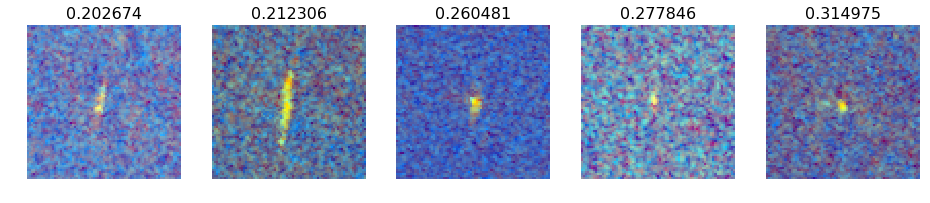

In [81]:
helper.plot(data,probs,y,image_path=PATH,condition=False)

     actual_y  predicted_y      prob
200         0            0  0.995971
299         0            0  0.993900
65          0            0  0.993845
56          0            0  0.993172
116         0            0  0.992392
Most correctly classified for ice


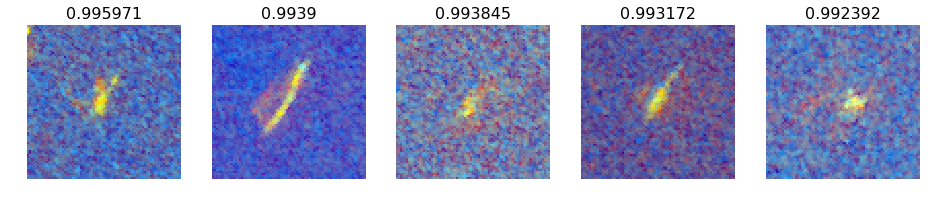

In [82]:
helper.plot(data,probs,y,image_path=PATH,condition=True)

     actual_y  predicted_y      prob
270         1            0  0.094208
209         1            0  0.100882
95          1            0  0.158338
64          1            0  0.167692
219         1            0  0.242133
Most incorrectly classified for ship


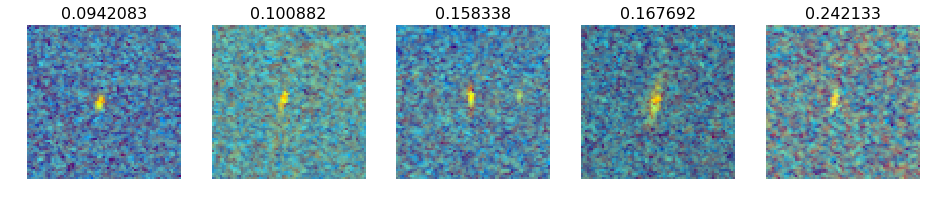

In [83]:
helper.plot(data,probs,y,image_path=PATH,condition=False,label=1)

     actual_y  predicted_y      prob
258         1            1  0.999903
117         1            1  0.999508
122         1            1  0.998476
47          1            1  0.997707
128         1            1  0.997256
Most correctly classified for ship


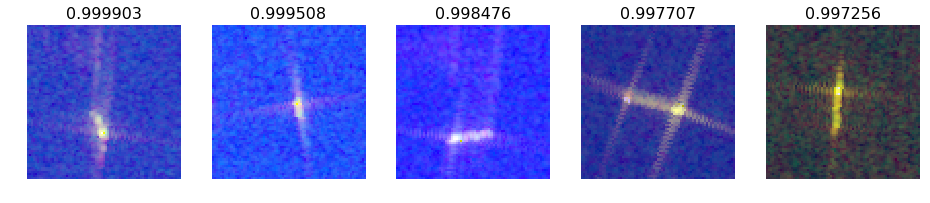

In [84]:
helper.plot(data,probs,y,image_path=PATH,condition=True,label=1)

In [35]:
# print number of files in each folder
print("training data")
!ls -l {PATH}train-jpeg| grep ^[^d] | wc -l

print("testing data")
!ls -l {PATH}test-jpeg| grep ^[^d] | wc -l


training data
1606
testing data
8425


---